In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

data = pd.read_csv(f"newdata_v1.csv")

In [18]:
# main hastags to be used
main_hashtags = ['climatechange',
                'climatecrisis',
                'climateaction',
                'saveearth',
                'globalwarming',
                'savetheplanet',
                'climateemergency']

hashtags = []
groups_of_hashtags = [] # needed for #5 to create edges
individual_hashtags = []
for msg in data['Hashtags']:
    hashtags_in_msg = []
    for hashtag in msg.split():
        tag = hashtag.strip('\'.,[]').lower().replace('\\', '').replace('/', '').replace(':', '')
        if "…" not in tag and "http" not in tag:
            hashtags.append(tag)
            hashtags_in_msg.append(tag)
            if tag not in individual_hashtags:
                individual_hashtags.append(tag)
    groups_of_hashtags.append(hashtags_in_msg)
                
# all individual usernumbers per main hashtag
individual_users = dict.fromkeys(main_hashtags, [])

# number of tweets per main hashtag
num_of_tweets = dict.fromkeys(main_hashtags, 0)

# count of individual users per main hashtag
individual_users_count = dict.fromkeys(main_hashtags, 0)

users = data['Username']

for index, tweet_hashtags in enumerate(data['Hashtags']):
    for hashtag in main_hashtags:
        if hashtag in tweet_hashtags:
            num_of_tweets[hashtag] += 1
            if users[index] not in individual_users[hashtag]:
                individual_users[hashtag].append(users[index])
                individual_users_count[hashtag] += 1

4514
{'climatechange': 2005, 'climatecrisis': 1890, 'climateaction': 542, 'saveearth': 91, 'globalwarming': 540, 'savetheplanet': 288, 'climateemergency': 929}
{'climatechange': 1582, 'climatecrisis': 1348, 'climateaction': 76, 'saveearth': 15, 'globalwarming': 254, 'savetheplanet': 121, 'climateemergency': 434}


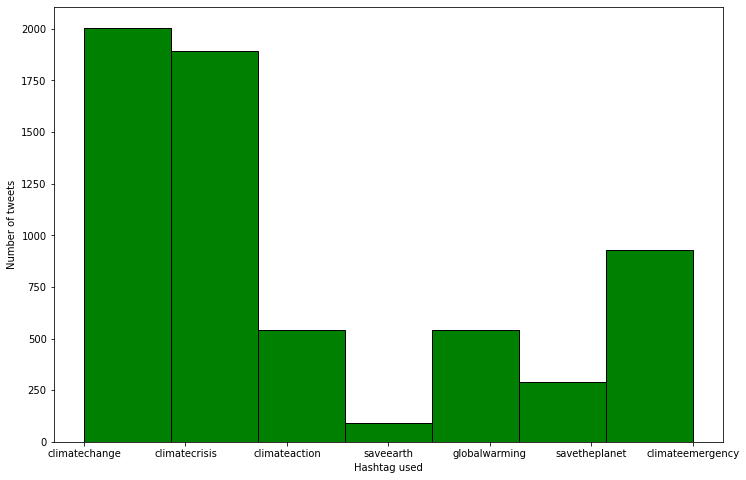

In [19]:
#show number of tweets per hashtag
plt.figure(figsize=(12,8))
number_of_tweets = [key for key, val in num_of_tweets.items() for _ in range(val)]
plt.hist(number_of_tweets, bins=7, color='green',edgecolor='black')
plt.ylabel('Number of tweets')
plt.xlabel('Hashtag used')
plt.show()

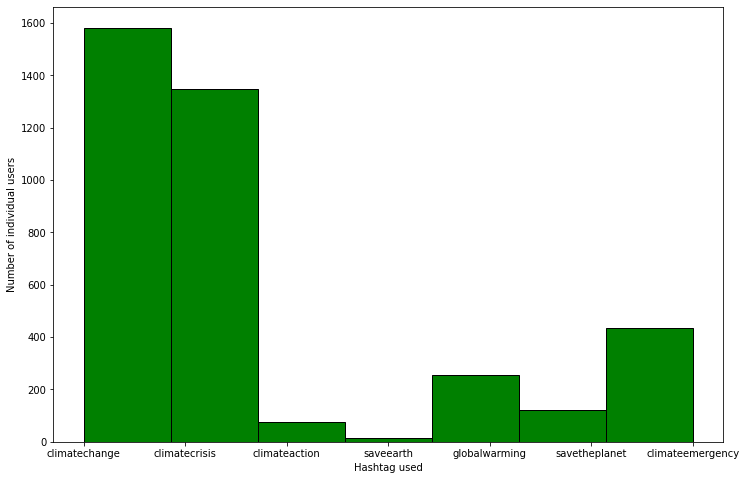

In [20]:
#show number of users per hashtag
plt.figure(figsize=(12,8))
number_of_users = [key for key, val in individual_users_count.items() for _ in range(val)]
plt.hist(number_of_users, bins=7, color='green',edgecolor='black')
plt.ylabel('Number of individual users')
plt.xlabel('Hashtag used')
plt.show()

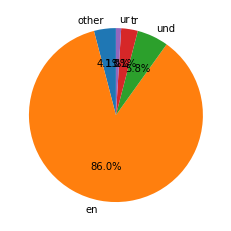

In [21]:


# list of languages in tweets
languages = []
for tweet_lang in data['Language']:
    if tweet_lang not in languages:
        languages.append(tweet_lang)
        
# dict for number of tweets per language
lang_count = dict.fromkeys(languages, 0)

for tweet in data['Language']:
    for lang in languages:
        if lang in tweet:
            lang_count[lang] += 1

# sort dictionary by value
lang_count = dict(sorted(lang_count.items(), key=lambda item: item[1], reverse=True))

# labels dict for showing 5 most popular languages
# init 'other' to prevent keyerror
labels = {'other': 0}

for index, lang in enumerate(lang_count.keys()):
    if index >= 4:
        labels['other'] += lang_count[lang]
    else:
        labels[lang] = lang_count[lang]

fig1, ax1 = plt.subplots()
ax1.pie(labels.values(), labels=labels.keys(), autopct='%1.1f%%', startangle=90)

plt.show()

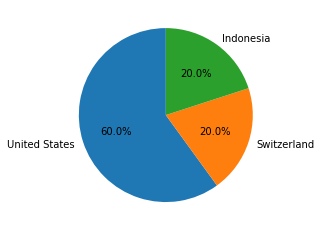

In [22]:
import ast
import reverse_geocoder as rg
import pycountry

#show geographic information of the tweets

countries = {}

for geodata in data['Geo']:
    if type(geodata) != float:
        geodata = ast.literal_eval(geodata)
        if 'coordinates' in geodata:
            latlong = (geodata['coordinates']['coordinates'][1], geodata['coordinates']['coordinates'][0])
            location = rg.search(latlong)
            country = pycountry.countries.get(alpha_2=location[0]['cc']).name
            if country not in countries:
                countries[country] = 1
            else:
                countries[country] += 1
        
fig1, ax1 = plt.subplots()
ax1.pie(countries.values(), labels=countries.keys(), autopct='%1.1f%%', startangle=90)

plt.show()

In [23]:
#vader tool analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
vader_data = []
for sentence in data['Text']:
    vs = analyzer.polarity_scores(sentence)
    vader_data.append(vs)
    #print("{} {}".format(index, vs))
    
fig = px.scatter_ternary(vader_data, a="neg", b="neu", c="pos")
fig.show()

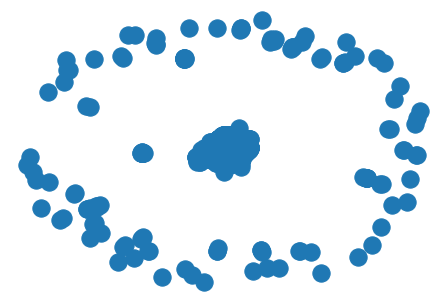

In [24]:
#construct a social graph
import networkx as nx

G = nx.Graph()

for hashtag in individual_hashtags:
    G.add_node(hashtag)

for group in groups_of_hashtags: # groups_of_hashtags is initialized at #1
    for hashtag in group:
        for other_hashtag in group:
            if hashtag != other_hashtag:
                G.add_edge(hashtag, other_hashtag)

nx.draw(G)

In [25]:
#calculate main global properties of the graph
# number of nodes in variable
num_nodes = G.number_of_nodes()
# number of edges in variable 
num_edges = G.number_of_edges()
# degree centrality in a variable
degree_centrality = nx.degree_centrality(G)
degree = nx.degree(G)

# average degree centrality
average_degree_centrality = sum(degree_centrality.values())/num_nodes

try:
        dia = nx.diameter(G)
except nx.NetworkXError:
        dia = "infinite (not connected)"

clustering_coefficient = nx.average_clustering(G)

# size of the largest component
components = [x for x in nx.connected_components(G)]
largest_component = max(components, key=len)

graph_data = {'Number of nodes': num_nodes,
              'Number of edges': num_edges,
              'Average degree centrality': average_degree_centrality,
              'Diameter': dia,
              'Clustering coefficient': clustering_coefficient,
              'Size of largest component': len(largest_component)}

main_properties_dataframe = pd.DataFrame(graph_data, index=['Normal properties'])
print(main_properties_dataframe)

2309 1632 773 828
                   Number of nodes  Number of edges  \
Normal properties             4514            29558   

                   Average degree centrality                  Diameter  \
Normal properties                   0.002902  infinite (not connected)   

                   Clustering coefficient  Size of largest component  
Normal properties                0.834962                       4374  


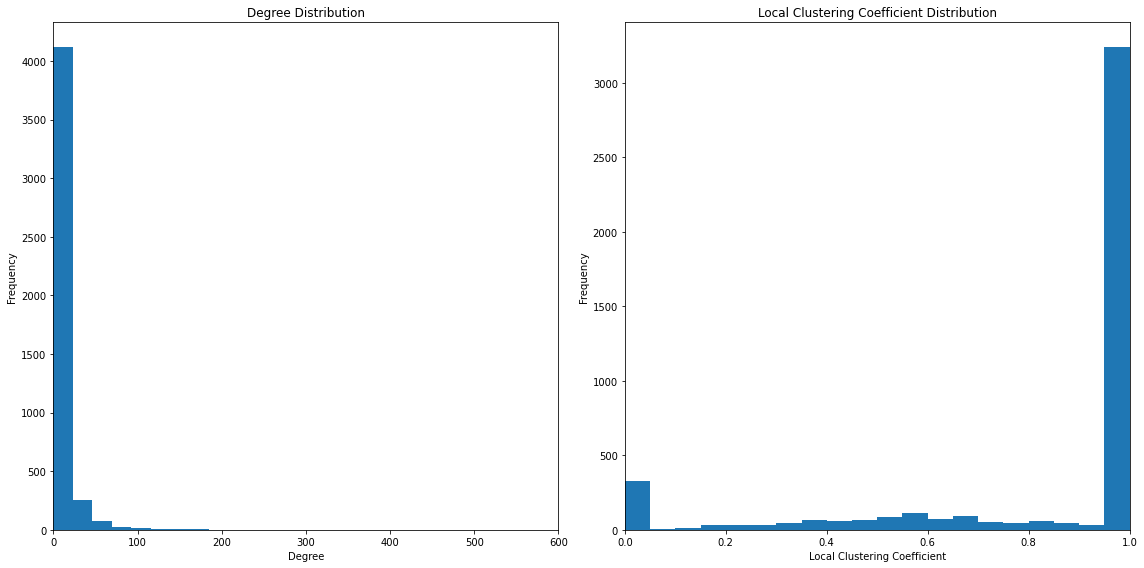

In [26]:
# plot clustering coefficient and degree
local_clustering_sequence = sorted(nx.clustering(G).values(), reverse=True)
degrees = [val for (node, val) in sorted(G.degree(), key=lambda pair: pair[0])]

degrees = sorted(degrees)
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.hist(degrees, label=None, stacked=False, density=False, bins=100)
ax1.set_title("Degree Distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Frequency")
ax1.set_xlim(0, 600)
ax1.tick_params(axis='x', which='minor', bottom=True, labelbottom=False)

ax2 = fig.add_subplot(122)
ax2.hist(local_clustering_sequence, bins=20)
ax2.set_title("Local Clustering Coefficient Distribution")
ax2.set_xlabel("Local Clustering Coefficient")
ax2.set_xlim(0, 1)
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [27]:
# label propagation algorithm for finding communities
communities = nx.algorithms.community.label_propagation.label_propagation_communities(G)
communities = [list(x) for x in communities]

# graph of communities
G_com = nx.Graph()
        
for community in communities:
    G_com.add_nodes_from(community)
    edges = [(a, b) for idx, a in enumerate(community) for b in community[idx + 1:]]
    G_com.add_edges_from(edges)
    

# number of nodes in variable
num_nodes_com = G_com.number_of_nodes()
# number of edges in variable 
num_edges_com = G_com.number_of_edges()

degree_centrality_com = nx.degree_centrality(G_com)
degree_com = nx.degree(G_com)

# average degree centrality
average_degree_centrality_com = sum(degree_centrality_com.values())/num_nodes_com

try:
        dia_com = nx.diameter(G_com)
except nx.NetworkXError:
        dia_com = "infinite (not connected)"

ering_coefficient_com = nx.average_clustering(G_com)
# clustering_coefficient_com = "Unknown"

# size of the largest component
components_com = [x for x in nx.connected_components(G_com)]
largest_component_com = max(components_com, key=len)


com_data = {'Number of nodes': num_nodes_com,
        'Number of edges': num_edges_com,
        'Average degree centrality': average_degree_centrality_com,
        'Diameter': dia_com,
        'Clustering coefficient': clustering_coefficient_com,
        'Size of largest component': len(largest_component_com)}

com_properties_dataframe = pd.DataFrame(com_data, index=['Community properties'])
compare_properties_dataframe = pd.concat([main_properties_dataframe, com_properties_dataframe])
print(compare_properties_dataframe)

In [ ]:
#task 10: rank tweets according to the number of likes and retweets
tweet_score_rankings = []

#initialize list for calculating rankings
for tag in individual_hashtags:
    tweet_score_rankings.append((tag, 0))
    

for index, tags in enumerate(data['Hashtags']):
    #if retweet, dont calculate score since all the data transfers from the original tweet to retweets
    if data['Text'][index].startswith("RT"):
        continue
    
    likes = np.sqrt(data['Likes'][index])
    retweets = np.sqrt(data['Retweets'][index])
    
    final_score = likes+(retweets*3)
    
    #loop through the hashtags in this tweet
    for tag in tags.split():
        #clean the tag
        tag = tag.strip('\'.,[]').lower().replace('\\', '').replace('/', '').replace(':', '')
        
        #add new score to all hashtags that were included in this tweet
        for j, one_tag in enumerate(tweet_score_rankings):
            if tweet_score_rankings[j][0] == tag:
                tweet_score_rankings[j] = (tweet_score_rankings[j][0], tweet_score_rankings[j][1]+final_score)

#sort the ranking list
sorted_rankings = sorted(tweet_score_rankings, key=lambda tup: tup[1], reverse=True)

#50 best ranked tweets
for i in range(50):
    print(sorted_rankings[i])